In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from pandas import DataFrame, Series
from numpy import nan as NA

In [78]:
def summ(x,label):
    percentile=np.percentile(x,[2.5,25,50,75,97.5]).tolist()
    summ=[np.mean(x),np.std(x)]
    summ.extend(percentile)
    summ=DataFrame(summ,index=["mean","sd","2.5%","25%","50%","75%","97.5%"],columns=[label]).T
    return summ

In [12]:
data=DataFrame([[83,92,92,46,67],[117,109,112,104,87],[101,93,92,86,67],[105,119,116,102,116],[79,97,103,79,92],[57,92,104,77,100]]).T
data_pooled=np.array([83,92,92,46,67,117,109,112,104,87,101,93,92,86,67,105,119,116,102,116,79,97,103,79,92,57,92,104,77,100])

In [3]:
data

,0,1,2,3,4,5
0,83,117,101,105,79,57
1,92,109,93,119,97,92
2,92,112,92,116,103,104
3,46,104,86,102,79,77
4,67,87,67,116,92,100


In [147]:
def gibbs_pooled(y,iteration,warm_up=0):
    y_bar=np.mean(y)
    n=len(y)
    theta=[]
    sigma2=[1.0]
    for i in range(iteration):
        theta.append(np.random.normal(y_bar,np.sqrt(sigma2[i]/n)))
        sigma2.append((n+2)*np.mean(np.square(y-theta[i]))/sp.stats.chi2.rvs(df=n+2))
    del sigma2[0]
    return np.array([theta[warm_up:],sigma2[warm_up:]])

def gibbs_hierarchical(data,iteration,warm_up=0):
    y_bar=np.mean(data)
    n=len(data.ix[:,0])
    J=len(data.T)
    
    theta=[]
    sigma2=[]
    for j in range(J):
        theta.append([])
        sigma2.append([1.0])
    mu=[0.0]
    tau=[1.0]
    
    for i in range(iteration):
        theta_temp=[]

        for j in range(J):
            theta_bar=1.*(sigma2[j][i]*mu[i]+tau[i]*n*y_bar[j])/(sigma2[j][i]+tau[i]*n)
            V_thetaj=1.*(sigma2[j][i]*tau[i])/(sigma2[j][i]+tau[i]*n)
            
            theta[j].append(np.random.normal(theta_bar,np.sqrt(V_thetaj)))
            
            sigma2hat=1.*np.sum(np.sum(np.square(data.ix[:,j]-theta[j][i])))/n
            
            sigma2[j].append(n*sigma2hat/sp.stats.chi2.rvs(df=n))
            
            theta_temp.append(theta[j][i])
            
        theta_temp=np.array(theta_temp)
        
        tau2hat=1./(J-1)*np.sum(np.square(theta_temp-mu[i]))
        muhat=np.mean(theta_temp)
        
        tau.append((J-1)*tau2hat/sp.stats.chi2.rvs(df=J-1))
        mu.append(np.random.normal(muhat,np.sqrt(tau[i+1]/J)))
        
    for j in range(len(theta)):
        theta[j]=theta[j][warm_up:]
        del sigma2[j][0]
        sigma2[j]=sigma2[j][warm_up:]

    del tau[0]
    del mu[0]
    return np.array([theta,sigma2,mu[warm_up:],tau[warm_up:]])

In [145]:
#separate
param_separate=[]
for i in range(6):
    param_separate.append(gibbs_pooled(data.ix[:,i],10000,5000))

In [114]:
y_separate=[]
for i in range(6):
    y_separate.append(np.random.normal(param_separate[i][0],np.sqrt(param_separate[i][1])))

In [112]:
#(ⅰ)
for i in range(6):
    print summ(param_separate[i][0],"machine {}".format(i+1))

                mean         sd       2.5%        25%        50%        75%  \
machine 1  75.838042  10.829184  53.291326  69.799924  75.950388  82.233074   

               97.5%  
machine 1  97.496065  
                 mean        sd       2.5%         25%         50%  \
machine 2  105.873775  6.145678  93.810592  102.164889  105.815277   

                  75%       97.5%  
machine 2  109.504099  118.110069  
                mean        sd       2.5%        25%        50%        75%  \
machine 3  87.725226  7.001522  73.696565  83.728019  87.697064  91.682617   

                97.5%  
machine 3  101.956275  
                 mean        sd        2.5%         25%         50%  \
machine 4  111.430162  4.230966  102.713377  109.075081  111.502849   

                  75%       97.5%  
machine 4  113.892318  119.789203  
                mean        sd       2.5%        25%        50%        75%  \
machine 5  89.999981  6.016149  77.920107  86.479808  90.030804  93.409752   

     

In [113]:
for i in range(6):
    print summ(param_separate[i][1],"machine {}".format(i+1))

                mean          sd        2.5%         25%         50%  \
machine 1  597.69313  825.283709  151.393785  284.207477  423.143115   

                  75%        97.5%  
machine 1  672.708739  2006.323938  
                 mean         sd       2.5%        25%         50%  \
machine 2  198.163178  202.93319  51.806441  99.082689  146.997225   

                  75%       97.5%  
machine 2  224.675204  662.614429  
                 mean          sd       2.5%         25%         50%  \
machine 3  254.382677  258.840952  64.287772  120.207765  180.951275   

                  75%       97.5%  
machine 3  292.664204  912.023947  
                mean          sd       2.5%        25%        50%         75%  \
machine 4  90.085291  100.032921  22.957051  42.636881  63.810788  102.298671   

                97.5%  
machine 4  307.968434  
                 mean          sd     2.5%        25%         50%         75%  \
machine 5  181.211786  180.087783  46.8423  84.990797  129.

In [116]:
#(ⅱ)predictive values
for i in range(6):
    print summ(y_separate[i],"machine {}".format(i+1))

                mean         sd       2.5%        25%       50%        75%  \
machine 1  75.461074  27.101027  21.171407  60.755577  75.55721  90.621452   

                97.5%  
machine 1  129.821124  
                 mean         sd       2.5%        25%         50%  \
machine 2  106.086188  15.434096  76.473151  97.263752  106.016606   

                  75%       97.5%  
machine 2  114.767268  136.202817  
                mean         sd       2.5%        25%        50%        75%  \
machine 3  87.890508  16.814975  53.822878  77.835366  88.074986  98.065835   

                97.5%  
machine 3  121.165659  
                 mean         sd       2.5%         25%         50%  \
machine 4  111.351814  10.416624  90.463918  105.595447  111.310664   

                  75%       97.5%  
machine 4  117.351815  131.621314  
                mean         sd       2.5%        25%        50%        75%  \
machine 5  90.215033  14.709505  60.875583  81.632234  90.189648  98.707157   

 

In [102]:
#(ⅰ)
summ(param_pooled[0],r"$\theta$")

,mean,sd,2.5%,25%,50%,75%,97.5%
$\theta$,92.904271,3.39882,86.231366,90.646305,92.864865,95.155185,99.701124


In [103]:
summ(param_pooled[1],r"$\sigma^2$")

,mean,sd,2.5%,25%,50%,75%,97.5%
$\sigma^2$,342.34128,93.019706,205.926029,277.960902,326.366492,391.108043,565.382077


In [117]:
#(ⅱ)predictive values
y_pooled=np.random.normal(param_pooled[0],np.sqrt(param_pooled[1]))

In [119]:
summ(y_pooled,r"$y_{rep}$")

,mean,sd,2.5%,25%,50%,75%,97.5%
$y_{rep}$,93.572784,19.04159,56.531979,81.015246,93.657377,106.174612,131.113181


In [158]:
#hierarchical
param_hierarchical=gibbs_hierarchical(data,50000,45000)

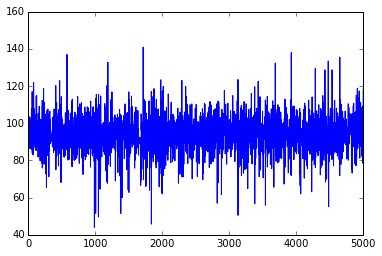

In [160]:
plt.plot(param_hierarchical[2])

In [163]:
for i in range(6):
    print summ(param_hierarchical[0][i],r"theta machine {}".format(i+1))

                      mean         sd      2.5%        25%       50%  \
theta machine 1  83.684509  10.079869  64.84229  77.051745  83.27371   

                       75%       97.5%  
theta machine 1  90.098701  104.187274  
                       mean        sd      2.5%        25%         50%  \
theta machine 2  103.347997  6.364662  89.78759  99.705919  103.693352   

                        75%       97.5%  
theta machine 2  107.328747  115.082546  
                      mean        sd       2.5%        25%        50%  \
theta machine 3  89.567532  6.695989  77.056644  85.536418  89.400156   

                      75%       97.5%  
theta machine 3  93.19106  103.882829  
                       mean        sd       2.5%         25%         50%  \
theta machine 4  108.978217  5.815864  92.729896  106.583248  109.941758   

                        75%       97.5%  
theta machine 4  112.513867  117.804769  
                      mean        sd       2.5%        25%        50%  \
the

In [164]:
for i in range(6):
    print summ(param_hierarchical[1][i],r"sigma2 machine {}".format(i+1))

                       mean           sd        2.5%         25%        50%  \
sigma2 machine 1  799.25262  1335.078315  142.692514  315.008772  503.54895   

                         75%        97.5%  
sigma2 machine 1  871.566109  3091.739096  
                       mean          sd       2.5%        25%         50%  \
sigma2 machine 2  253.45997  399.001905  48.060098  99.860417  160.402053   

                         75%        97.5%  
sigma2 machine 2  275.871884  1023.429346  
                        mean          sd       2.5%         25%         50%  \
sigma2 machine 3  293.534344  384.266636  59.097892  117.278753  185.065405   

                         75%        97.5%  
sigma2 machine 3  319.507217  1180.076274  
                        mean          sd     2.5%        25%       50%  \
sigma2 machine 4  145.907726  258.666826  21.5281  44.787296  75.23268   

                         75%       97.5%  
sigma2 machine 4  143.186797  730.920183  
                        mean

In [168]:
summ(param_hierarchical[2],r"mu machine")

,mean,sd,2.5%,25%,50%,75%,97.5%
mu machine,94.259383,8.033347,77.565799,90.052143,94.435405,98.663693,109.904038


In [170]:
summ(param_hierarchical[3],r"tau machine")

,mean,sd,2.5%,25%,50%,75%,97.5%
tau machine,338.822078,601.033076,12.75176,97.83808,188.288102,358.903542,1611.180822


In [171]:
y_hierarchical=np.random.normal(param_hierarchical[0],np.sqrt(param_hierarchical[1]))

In [173]:
summ(y_hierarchical,"y_rep")

,mean,sd,2.5%,25%,50%,75%,97.5%
y_rep,94.288655,22.854768,46.367155,81.663435,95.404618,108.430616,135.407229


In [174]:
theta_seventh=np.random.normal(param_hierarchical[2],np.sqrt(param_hierarchical[3]))

In [176]:
summ(theta_seventh,"theta_seventh")

,mean,sd,2.5%,25%,50%,75%,97.5%
theta_seventh,93.894341,19.620229,52.512931,84.577826,94.139345,103.879933,131.480552
